## Asignment: Computer vison course
- Alumno 1: Daniel Carmona Pedrajas
- Alumno 2:
- Alumno 3:

The goals of this assignment are:
+ Develop proficiency in using Tensorflow/Keras for training neural nets (NNs).
+ Put in practice Unit 4 knowledge to optimize the parameters and architecture of a feed-forward Neural Net (ffNN), in the context of a computer vision problem.
+ Use NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (cNN).

Follow the link above to download the classification benchmark termed “xview_recognition”: [https://drive.upm.es/s/c4gfDOOwWfPdm0z](https://drive.upm.es/s/c4gfDOOwWfPdm0z")

In [1]:
import zlib

In [2]:
images_path = "../../../xview_recognition/xview_recognition/"

In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {13: 'CARGO_PLANE', 15: 'HELICOPTER', 18: 'SMALL_CAR', 19: 'BUS', 23: 'TRUCK', 41: 'MOTORBOAT', 47: 'FISHING_VESSEL', 60: 'DUMP_TRUCK', 64: 'EXCAVATOR', 73: 'BUILDING', 86: 'STORAGE_TANK', 91: 'SHIPPING_CONTAINER'}

In [5]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories, normalize=False):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    if normalize:
        cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

#### Training
Design and train a ffNN to deal with the xview_recognition classification task

In [7]:
import json
# Load database
json_file = f'{images_path}xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [8]:
import numpy as np
counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(images_path + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    # Resampling strategy to reduce training time
    if counts[obj.category] >= 6000:
        continue
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
    
print(counts)

{'CARGO_PLANE': 5024, 'HELICOPTER': 392, 'SMALL_CAR': 6000, 'BUS': 6000, 'TRUCK': 6000, 'MOTORBOAT': 6000, 'FISHING_VESSEL': 5888, 'DUMP_TRUCK': 6000, 'EXCAVATOR': 5648, 'BUILDING': 6000, 'STORAGE_TANK': 6000, 'SHIPPING_CONTAINER': 6000}


In [9]:
from sklearn.model_selection import train_test_split
anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [10]:
# Load architecture
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
print('Load model')
num_filters = 8
filter_size = 3
pool_size = 2

model = Sequential([
    Conv2D(num_filters, 1, input_shape=(224, 224, 3),strides=2,padding='same',activation='relu',),
    
    Conv2D(num_filters, filter_size, strides=4,padding='same',activation='relu',),
    
    Flatten(),
    
    Dense(256),
    BatchNormalization(),
    Activation("relu"),
    
    Dense(128),
    BatchNormalization(),
    Activation("relu"),
    
    Dense(64),
    BatchNormalization(),
    Activation("relu"),
    
    Dense(len(categories)),
    BatchNormalization(),
    Activation("softmax"),
])

model.summary()

Load model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       32        
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         584       
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 256)               1605888   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                             

In [11]:
# Learning rate is changed to 0.001
from keras.optimizers import SGD
opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=False, name="SGD")
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Callbacks
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
model_checkpoint = ModelCheckpoint('convmodel.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [13]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 8
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [14]:
import math
import numpy as np
print('Training model')
epochs = 20
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/20
7307/7307 [==============================] - ETA: 0s - loss: 2.0638 - accuracy: 0.2904
Epoch 1: val_accuracy improved from -inf to 0.28695, saving model to convmodel.hdf5
7307/7307 [==============================] - 863s 117ms/step - loss: 2.0638 - accuracy: 0.2904 - val_loss: 2.1527 - val_accuracy: 0.2869 - lr: 0.0100
Epoch 2/20
7307/7307 [==============================] - ETA: 0s - loss: 1.8227 - accuracy: 0.3914
Epoch 2: val_accuracy improved from 0.28695 to 0.45705, saving model to convmodel.hdf5
7307/7307 [==============================] - 513s 70ms/step - loss: 1.8227 - accuracy: 0.3914 - val_loss: 1.6185 - val_accuracy: 0.4571 - lr: 0.0100
Epoch 3/20
7307/7307 [==============================] - ETA: 0s - loss: 1.6432 - accuracy: 0.4519
Epoch 3: val_accuracy improved from 0.45705 to 0.51062, saving model to convmodel.hdf5
7307/7307 [==============================] - 514s 70ms/step - loss: 1.6432 - accuracy: 0.4519 - val_loss: 1.4697 - val_accuracy: 0.510

In [15]:
import json
# Load database
json_file = f'{images_path}xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [16]:
import numpy as np
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(images_path + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    image.add_object(obj)
    anns.append(image)

In [17]:
import numpy as np
# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


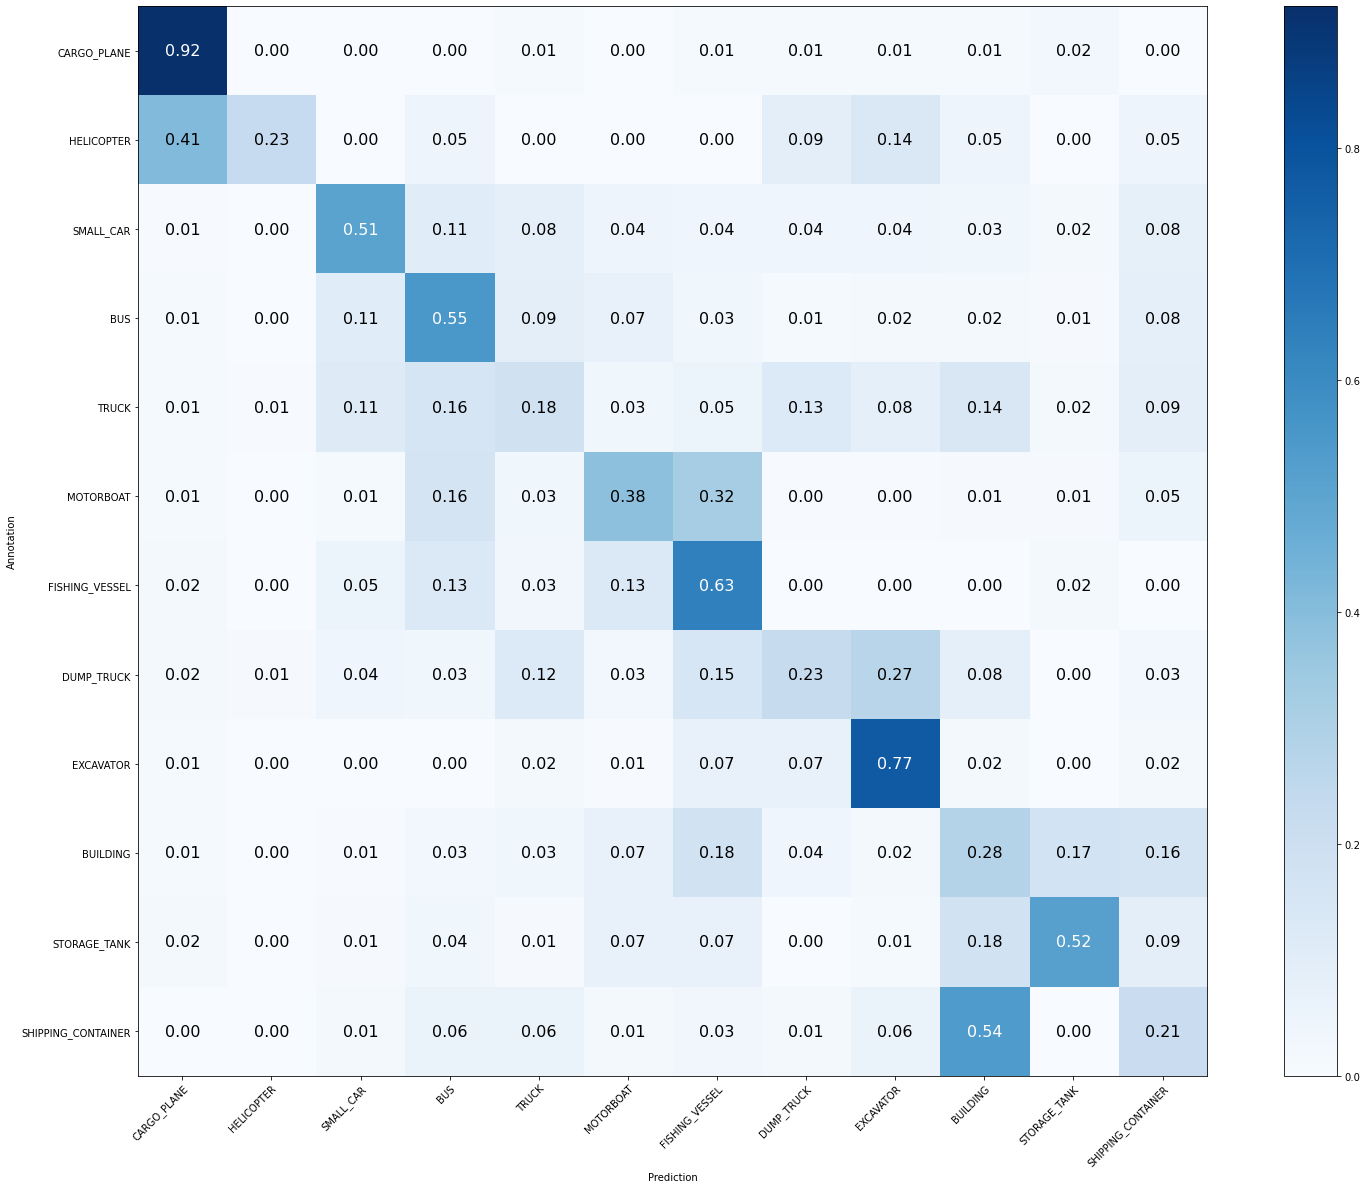

In [18]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories, normalize=True)

In [19]:
import numpy as np
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 35.618%
Mean Recall: 45.094%
Mean Precision: 20.027%
> CARGO_PLANE: Recall: 92.222% Precision: 13.409% Specificity: 98.981% Dice: 23.413%
> HELICOPTER: Recall: 22.727% Precision: 9.091% Specificity: 99.905% Dice: 12.987%
> SMALL_CAR: Recall: 50.705% Precision: 95.195% Specificity: 98.830% Dice: 66.167%
> BUS: Recall: 55.164% Precision: 7.258% Specificity: 94.252% Dice: 12.828%
> TRUCK: Recall: 18.076% Precision: 9.972% Specificity: 95.055% Dice: 12.853%
> MOTORBOAT: Recall: 38.362% Precision: 2.859% Specificity: 94.233% Dice: 5.321%
> FISHING_VESSEL: Recall: 63.492% Precision: 0.578% Specificity: 86.910% Dice: 1.145%
> DUMP_TRUCK: Recall: 22.500% Precision: 1.234% Specificity: 95.887% Dice: 2.340%
> EXCAVATOR: Recall: 77.143% Precision: 6.870% Specificity: 97.213% Dice: 12.617%
> BUILDING: Recall: 28.236% Precision: 91.566% Specificity: 95.571% Dice: 43.162%
> STORAGE_TANK: Recall: 51.600% Precision: 2.090% Specificity: 88.469% Dice: 4.017%
> SHIPPING_CONTAINER: Recall: 